In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sms-spam-collection-dataset/spam.csv
/kaggle/input/word2vec-model/GoogleNews-vectors-negative300.bin


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [21]:
import re
import string
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, GRU, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem.wordnet import WordNetLemmatizer

In [5]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding="latin-1")

In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.describe()

,target,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
df.isnull().sum()

target     0
message    0
dtype: int64

<Axes: xlabel='target'>

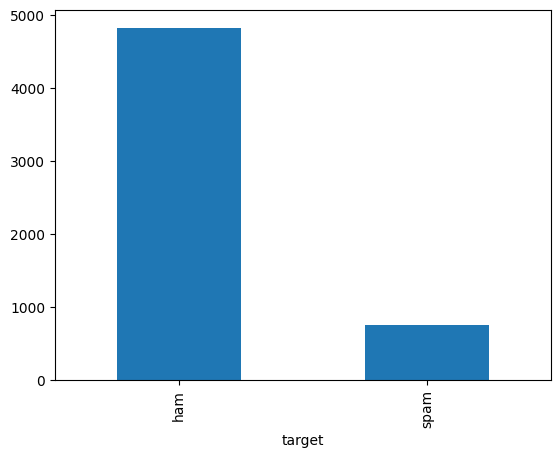

In [10]:
df['target'].value_counts().plot(kind='bar')

In [11]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lower case
    text = str(text).lower().strip()

    # Remove emoji
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F700-\U0001F77F"  # alchemical symbols
                                u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                u"\U00002702-\U000027B0"  # Dingbats
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove html
    pattern = re.compile('<.*?>')
    text = pattern.sub(r'', text)

    # Remove url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text)

    # Replace certain special characters with their string equivalents
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('[math]', '')

    # Contractions
    contractions = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }
    text_decontracted = []
    for word in text.split():
        if word in contractions:
            word = contractions[word]
        text_decontracted.append(word)
    text = ' '.join(text_decontracted)

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    text = re.sub(r'\d+', '', text)

    return text

df['message'] = df['message'].apply(preprocess)
df.head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target,message
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st...
3,ham,u dun say early hor u c already say
4,ham,nah think go usf life around though


In [12]:
genre_mapping = {genre: idx for idx, genre in enumerate(df['target'].unique())}
df['target'] = df['target'].map(genre_mapping)

In [13]:
word2vec_path = '/kaggle/input/word2vec-model/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Convert descriptions to vectors
def description_to_avg_vector(description):
    words = description.split()
    word_vectors = [word2vec[word] for word in words if word in word2vec]
    if len(word_vectors) == 0:
        return np.zeros(word2vec.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Apply the function to the dataframe
df['avg_vector'] = df['message'].apply(description_to_avg_vector)
df.head()

,target,message,avg_vector
0,0,go jurong point crazy available bugis n great ...,"[-0.019805908, 0.05167062, 0.02709961, 0.21868..."
1,0,ok lar joking wif u oni,"[-0.06323496, 0.0803833, 0.060943604, 0.102498..."
2,1,free entry wkly comp win fa cup final tkts st...,"[-0.022095999, -0.005947537, -0.08460829, 0.06..."
3,0,u dun say early hor u c already say,"[-0.06568061, 0.0262146, 0.1081543, 0.0869751,..."
4,0,nah think go usf life around though,"[-0.017473493, 0.029580252, 0.05126953, 0.2008..."


In [14]:
X = np.array(df['avg_vector'].tolist())
y = np.array(df['target'].tolist())

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
rf_classifier.score(X_train, y_train)

1.0

In [19]:
rf_classifier.score(X_test, y_test)

0.9596412556053812

In [22]:
y_pred = rf_classifier.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

F1 Score: 0.9565399730874923
Recall: 0.9596412556053812
Precision: 0.9614394174843491


In [23]:
xg_classifier = XGBClassifier()
xg_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
xg_classifier.score(X_train, y_train)

1.0

In [26]:
xg_classifier.score(X_test, y_test)

0.9713004484304932

In [27]:
y_pred = xg_classifier.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

F1 Score: 0.970609994126127
Recall: 0.9713004484304932
Precision: 0.9707948102495708


In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['message'])
len(tokenizer.word_index)

7924

In [29]:
df['Token_message'] = tokenizer.texts_to_sequences(df['message'])
df.head(3)

,target,message,avg_vector,Token_message
0,0,go jurong point crazy available bugis n great ...,"[-0.019805908, 0.05167062, 0.02709961, 0.21868...","[5, 3631, 263, 570, 543, 1058, 38, 58, 244, 87..."
1,0,ok lar joking wif u oni,"[-0.06323496, 0.0803833, 0.060943604, 0.102498...","[7, 226, 1202, 340, 1, 1581]"
2,1,free entry wkly comp win fa cup final tkts st...,"[-0.022095999, -0.005947537, -0.08460829, 0.06...","[6, 353, 605, 745, 96, 1582, 874, 497, 1583, 1..."


In [30]:
max_len = max(len(Token_message) for Token_message in df['Token_message'])
max_len

79

In [31]:
df['Token_message'] = pad_sequences(df['Token_message'], maxlen=max_len, padding='pre').tolist()

In [49]:
X = np.array(df['Token_message'].tolist())
y = np.array(df['target'].tolist())

In [60]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for padding

model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len))
model1.add(Bidirectional(LSTM(64)))

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())  

model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.2)) 
model1.add(BatchNormalization()) 

model1.add(Dense(1, activation='sigmoid'))  # Binary classification

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
import tensorflow as tf

stored_parameters1 = []

# Define your callback function to store model parameters
def your_callback_function(model):
    parameters = model.get_weights()  # Get model parameters (weights and biases)
    stored_parameters1.append(parameters)

# Assuming 'model' is defined and compiled before this step
history = model1.fit(
    X, y,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: your_callback_function(model1)
        )
    ]
)

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7148 - loss: 0.5640 - val_accuracy: 0.8915 - val_loss: 0.3693
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9695 - loss: 0.1500 - val_accuracy: 0.9713 - val_loss: 0.1894
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9915 - loss: 0.0582 - val_accuracy: 0.9722 - val_loss: 0.1118
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9933 - loss: 0.0390 - val_accuracy: 0.9839 - val_loss: 0.0646
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9953 - loss: 0.0299 - val_accuracy: 0.9785 - val_loss: 0.0896
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9957 - loss: 0.0235 - val_accuracy: 0.9794 - val_loss: 0.0795
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9960 - loss: 0.0208 - val_accuracy: 0.9776 - val_loss: 0.0835
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9935 - loss: 0.0287 - val_accu

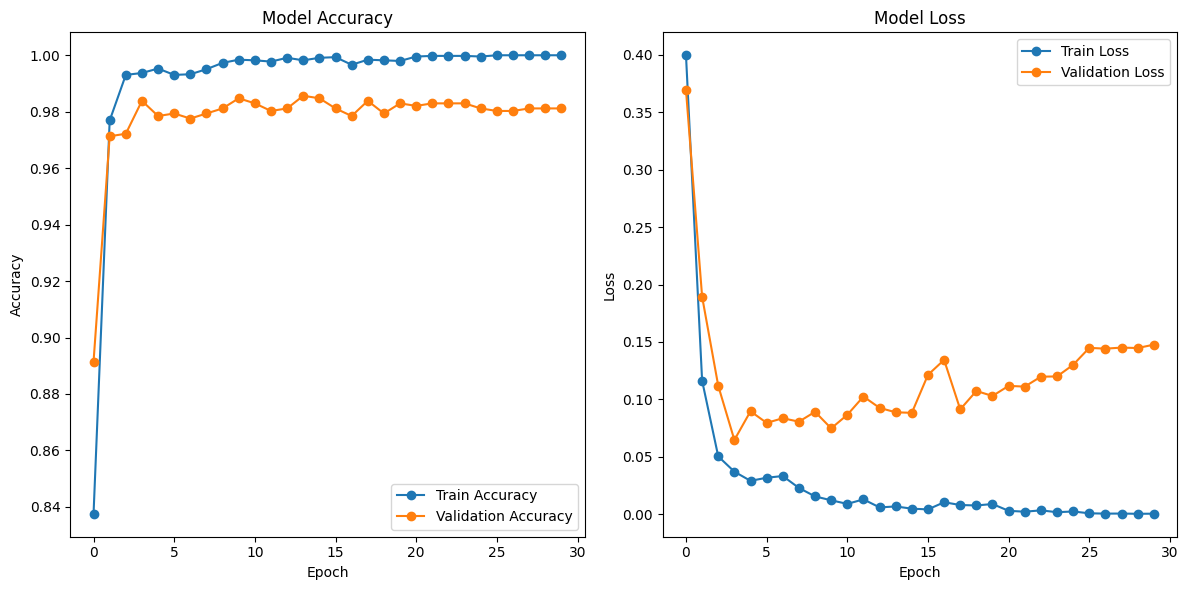

In [62]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [63]:
model1.set_weights(stored_parameters1[3])

In [64]:
y_pred = model1.predict(X)
y_pred_labels = (y_pred > 0.5).astype(int) 

precision = precision_score(y, y_pred_labels)
recall = recall_score(y, y_pred_labels)
f1 = f1_score(y, y_pred_labels)


print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Precision: 0.9903846153846154
Recall: 0.965194109772423
F1 Score: 0.9776271186440678


In [65]:
# Load pre-trained Word2Vec model
word2vec_path = '/kaggle/input/word2vec-model/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vocab_size = len(tokenizer.word_index) + 1
# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, word2vec.vector_size))
for word, index in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[index] = word2vec[word]
    else:
        embedding_matrix[index] = np.random.randn(word2vec.vector_size)

In [66]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=word2vec.vector_size, weights=[embedding_matrix], input_length=max_len, trainable=False))
model2.add(Bidirectional(LSTM(64)))

model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())  

model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2)) 
model2.add(BatchNormalization()) 
model2.add(Dense(1, activation='sigmoid'))  # Binary classification

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     2,377,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,377,500 (9.07 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,377,500 (9.07 MB)

In [67]:
stored_parameters2 = []

# Define your callback function to store model parameters
def your_callback_function(model):
    parameters = model.get_weights()  # Get model parameters (weights and biases)
    stored_parameters2.append(parameters)

# Assuming 'model' is defined and compiled before this step
history = model2.fit(
    X, y,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: your_callback_function(model2)
        )
    ]
)

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6629 - loss: 0.6286 - val_accuracy: 0.9722 - val_loss: 0.3663
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9528 - loss: 0.2101 - val_accuracy: 0.9668 - val_loss: 0.2015
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9733 - loss: 0.1117 - val_accuracy: 0.9650 - val_loss: 0.1205
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9844 - loss: 0.0684 - val_accuracy: 0.9803 - val_loss: 0.0817
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9832 - loss: 0.0706 - val_accuracy: 0.9740 - val_loss: 0.0828
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9911 - loss: 0.0411 - val_accuracy: 0.9677 - val_loss: 0.0937
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9900 - loss: 0.0436 - val_accuracy: 0.9776 - val_loss: 0.0801
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9939 - loss: 0.0332 - val_accu

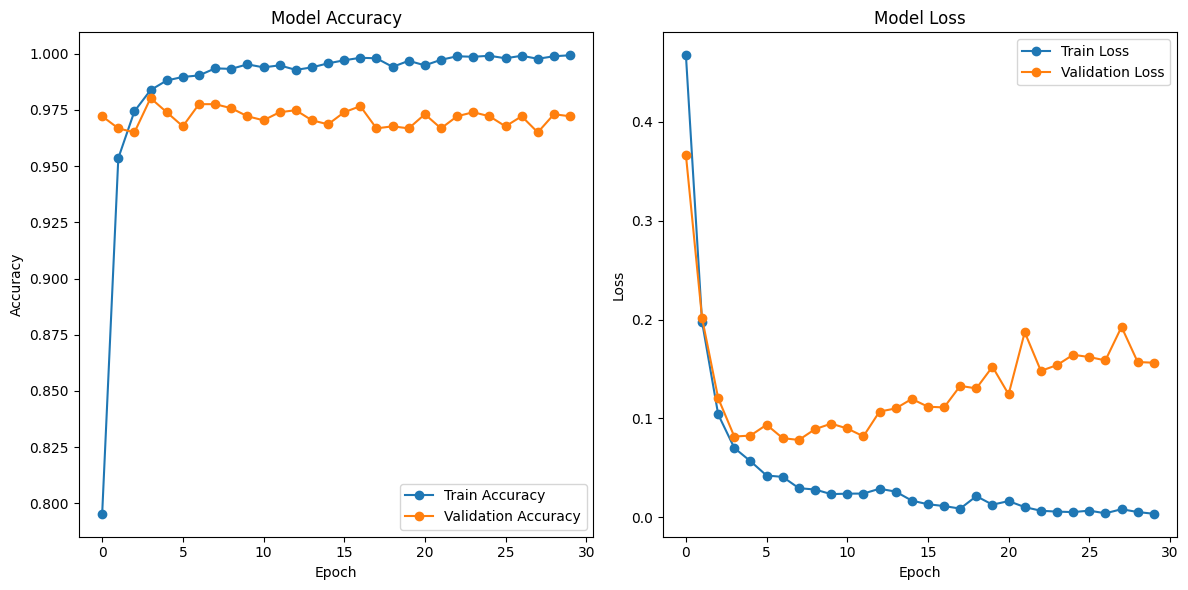

In [68]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [74]:
model2.set_weights(stored_parameters2[11])

In [76]:
y_pred = model2.predict(X)
y_pred_labels = (y_pred > 0.5).astype(int) 

precision = precision_score(y, y_pred_labels)
recall = recall_score(y, y_pred_labels)
f1 = f1_score(y, y_pred_labels)


print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Precision: 0.9822646657571623
Recall: 0.963855421686747
F1 Score: 0.9729729729729729
